In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import seaborn as sns
import sklearn
import warnings
import miceforest as mf
import xgboost as xgb
import lightgbm as lgb
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV

from joblib import dump, load
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


from sklearn.exceptions import DataConversionWarning, FitFailedWarning, ConvergenceWarning

In [13]:
path = 'data/weatherAUS.csv'


data = pd.read_csv(path,sep=',')
data.drop_duplicates(inplace=True)

#drop rows with null in target column
data.dropna(subset=['RainTomorrow'], inplace=True)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [14]:
data[['Year','Month', 'Day']] = data['Date'].str.split('-', expand=True)
data.drop(columns=['Day','Date'], inplace=True)

# Converting columns to numeric
#data['Year'] = pd.to_numeric(data['Year'], errors='coerce', downcast='integer')
data['Month'] = pd.to_numeric(data['Month'], errors='coerce', downcast='integer')

month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

data['Month'] = data['Month'].map(month_names)

columns = list(data.columns)
columns.insert(0, columns.pop(columns.index('Month')))
columns.insert(0, columns.pop(columns.index('Year')))
data = data[columns]

In [15]:
categorical_columns = data.select_dtypes(include=['int16','object', 'category']).columns.to_numpy()
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.to_numpy()

# Data Preparation 

Here we will prepare data for the model. We have already done some feature engineering ('Date' with 'Year' and 'Month')
<br>
<br>
Now we need to:
<br>
 - take care of missing values (using imputer)
<br>
 - encode categorical values (one-hot-encoding because ordinal doesn seem to suit such features like location or month)
<br>
 - scale numerical features (most of the features distributions are quite Gaussian-like therefore we will use StandardScaler, for the rest we will use MinMax)
<br>
 - maybe add polynomial features (from pairplot we can see that some relations between the target and feature are non-linear)

Lets drop rows with more than 9 null values

In [16]:
data = data.dropna(thresh=data.shape[1] - 10 + 1)

Now we will transform categorical features into numerical using one-hot encoding. This solution seems more suitable for such features like month or time of day because it hard to order them without incorrect or at least risky assumptions. We will of course use drop_first because for example if the measurement wasnt conducted in one of the 11 months it was certainly conducted in the 12th month.

In [17]:
missing_percentage = (data[categorical_columns].isnull().sum() / len(data)) * 100
print(missing_percentage)

Year            0.000000
Month           0.000000
Location        0.000000
WindGustDir     5.433665
WindDir9am      6.141691
WindDir3pm      1.473863
RainToday       0.802952
RainTomorrow    0.000000
dtype: float64


Here we will split dataframe into X - with independent features and y - with our target, dependent feature.

In [18]:
feature_cols = data.columns
feature_cols = feature_cols[feature_cols != 'RainTomorrow']
categorical_features = categorical_columns[categorical_columns != 'RainTomorrow']
target_col = ['RainTomorrow']


X = data[feature_cols]
y = data[target_col]
X = mf.utils.ampute_data(X)

#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

Below we impute missing numerical values using Multiple Imputation by Chained Equations (MICE) algorithm. It imputs values in one column based on the rest of columns and repeat this for every column and for a desired number of iterations (cycles) over all of columns.

In [19]:
pipe_kernel = mf.ImputationKernel(X[numerical_columns], datasets=1)

mice_pipe = Pipeline([
    ('impute', pipe_kernel),
])

X_numerical = mice_pipe.fit_transform(
    X[numerical_columns],
    impute__iterations=2
)

X = pd.concat([X_numerical, X[categorical_features]], axis=1)
# Show that neither now have missing values.
assert not np.any(np.isnan(X_numerical))

A tiny problem with this approach is that we impute float values in clearly integer type columns (such as 'Cloud9am' and 'Cloud3pm'). But since this is not our target and this categories are highly ordinal (this is just a scale of cloudiness) it might actually not perform so bad.
<br>
<br>
And of course scaling the numerical features using standard scaler. We assume that our features come from a distribution close to a Gaussian.

In [20]:
numeric_transformer     = Pipeline([
('std_scaler', StandardScaler())
#('poly-features', PolynomialFeatures(degree=2))
])

#numerical_columns_for_transformation = numerical_columns[numerical_columns != 'C6H6(GT)']

preprocessor            = ColumnTransformer([
    ('numeric_preprocess', numeric_transformer, numerical_columns),
]  , remainder='passthrough')


X = preprocessor.fit_transform(X)
X = pd.DataFrame(X, columns=np.append(numerical_columns,categorical_features))

In [21]:
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Cloud3pm,Temp9am,Temp3pm,Year,Month,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,0.187936,-0.050949,-0.206976,-0.49125,-1.077054,0.301969,0.672643,0.606578,0.114401,-1.419307,...,-0.197316,-0.011926,-0.26566,2008,December,Albury,W,W,WNW,No
1,-0.753021,0.259605,-0.278806,-0.044152,0.954078,0.301969,-1.131919,0.379051,-1.304576,-1.274562,...,0.549488,0.034322,0.368623,2008,December,Albury,WNW,NNW,WSW,NaN
2,0.109523,0.344301,-0.278806,0.005526,1.165104,0.449015,0.559858,0.834106,-1.619905,-1.033321,...,-0.944121,0.620132,0.210052,2008,December,Albury,WSW,W,WSW,No
3,-0.470734,0.668971,-0.278806,0.502303,0.927699,-1.168489,-0.342423,-1.099877,-1.252022,-1.708796,...,-1.690926,0.173066,0.685764,2008,December,Albury,NE,NaN,E,No
4,0.830923,1.261846,-0.159089,-0.044152,-0.232948,0.081401,-0.793564,0.151524,0.692503,-0.888576,...,1.296293,0.126818,1.147061,2008,December,Albury,W,ENE,NW,No


Now that we've dealt with missing numerical data, lets take care of missing categorical data. For that purpose we're gonna use KNNeighbors algorithm imputing missing value based on K most simmilar instances (measure by already filled numerical features).

In [22]:
categorical_cols_with_missing = [ 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Year', 'Month', 'Location']
knn_imputer = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

for col in categorical_cols_with_missing:
    X_train = X.dropna(subset=[col])  # Subset with complete data for the column
    X_test = X[X[col].isnull()]       # Subset with missing values for the column
    
    if len(X_test) > 0:  # Impute only if there are missing values in this column
        knn_imputer.fit(X_train[numerical_columns],X_train[col])  # Fit KNN on other columns except the one with missing values
        imputed_values = knn_imputer.predict(X_test[numerical_columns].values)  # Predict missing values
        
        col_index = X_test.columns.get_loc(col)
        X.loc[X[col].isnull(), col] = imputed_values  # Replace missing values in original dataset

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


Okay and finally we can use one-hot-encoding to replace our categorical features with binary features.

In [23]:
X = pd.get_dummies(X,drop_first=True,columns=categorical_features, dtype=int)
X.head(10)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
0,0.187936,-0.050949,-0.206976,-0.49125,-1.077054,0.301969,0.672643,0.606578,0.114401,-1.419307,...,0,0,0,0,0,0,0,1,0,0
1,-0.753021,0.259605,-0.278806,-0.044152,0.954078,0.301969,-1.131919,0.379051,-1.304576,-1.274562,...,0,0,0,0,0,0,0,0,1,0
2,0.109523,0.344301,-0.278806,0.005526,1.165104,0.449015,0.559858,0.834106,-1.619905,-1.033321,...,0,0,0,0,0,0,0,0,1,0
3,-0.470734,0.668971,-0.278806,0.502303,0.927699,-1.168489,-0.342423,-1.099877,-1.252022,-1.708796,...,0,0,0,0,0,0,0,0,0,0
4,0.830923,1.261846,-0.159089,-0.044152,-0.232948,0.081401,-0.793564,0.151524,0.692503,-0.888576,...,1,0,0,0,0,0,0,0,0,0
5,0.376127,0.908945,-0.254862,1.247467,1.428888,1.184244,0.559858,0.606578,-0.726474,-1.371059,...,0,0,0,0,0,0,1,0,0,0
6,0.329079,0.245489,-0.278806,0.402947,0.452889,0.743107,0.672643,0.606578,-1.041803,-1.564052,...,0,0,0,0,0,0,1,0,0,0
7,-0.705973,0.485462,-0.278806,-0.044152,-0.312083,-0.359737,-0.906349,-0.189767,-1.094358,-1.564052,...,0,0,0,0,0,0,1,0,0,0
8,-0.392321,1.219498,-0.278806,-0.093829,-0.180191,2.948795,-0.793564,1.061633,-1.146912,-2.046534,...,0,0,0,0,0,1,0,0,0,0
9,-0.674608,0.965409,-0.278806,1.992632,-1.077054,-0.874397,0.108718,-0.87235,-0.56881,-1.371059,...,0,0,0,1,0,0,0,0,0,1


Now we will split our data into train and test set. We will be applying resampling to the train data so we want to have balanced ratio of target classes in test set. Our dataset is quite big so we will only use 10% for testing.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Find the indices of each class in the test set
indices_class_0 = np.where(y_test == 'No')[0]
indices_class_1 = np.where(y_test == 'Yes')[0]

# Select an equal number of instances from each class for final test set
num_instances = min(len(indices_class_0), len(indices_class_1))
balanced_indices = np.concatenate([indices_class_0[:num_instances], indices_class_1[:num_instances]])

remaining_indices = np.setdiff1d(np.arange(len(X_test)), balanced_indices)
X_train = pd.concat([X_train, X_test.iloc[remaining_indices]])
y_train = pd.concat([y_train, y_test.iloc[remaining_indices]])

# Create the final balanced test set
X_test = X_test.iloc[balanced_indices]
y_test = y_test.iloc[balanced_indices]

In [25]:
y_train.replace({'Yes': 1, 'No': 0}, inplace=True)
y_test.replace({'Yes': 1, 'No': 0}, inplace=True)

In [26]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        try:
            X_train[col] = X_train[col].astype(float)
            X_test[col] = X_test[col].astype(float)
        except ValueError:
            print(f"Column '{col}' contains non-convertible values to float.")
    

y_train['RainTomorrow'] = y_train['RainTomorrow'].astype(int)
y_test['RainTomorrow'] = y_test['RainTomorrow'].astype(int)

In [27]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

Lets apply weights to reduce imbalances cause by underrepresentation of our positive class.

In [28]:
zero_counts = (y_train['RainTomorrow'] == 0).sum()
one_counts  = (y_train['RainTomorrow'] == 1).sum()

weight_for_0 = 1.0
weight_for_1 = zero_counts / one_counts  # Ratio of the number of 0 instances to the number of 1 instances

class_weights = {0: weight_for_0, 1: weight_for_1}

In [29]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

In [30]:
if 'X_train' not in locals():
    X_train = pd.read_csv('X_train.csv')
if 'X_test' not in locals():
    X_test = pd.read_csv('X_train.csv')
if 'y_train' not in locals():
    y_train = pd.read_csv('y_train.csv')
if 'y_test' not in locals():
    y_test = pd.read_csv('y_test.csv')

# CLASSIFICATION PROBLEM

## Model training

Lets create function for hyperparameter tuning:

In [31]:
def hyperparameter_tuning_cl(X_train, y_train, X_test, y_test, model_type, param_grid, cv, verb=1):

    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    warnings.filterwarnings(action='ignore', category=UserWarning)
    warnings.filterwarnings(action='ignore', category=FitFailedWarning)
    warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)

    if model_type == 'dec_tree':
        model = DecisionTreeClassifier(class_weight=class_weights)
    elif model_type == 'rand_forest':
        model = RandomForestClassifier(class_weight=class_weights)
    elif model_type == 'boosting':
        model = lgb.LGBMClassifier(verbose=0,class_weight=class_weights)
    else:
        raise ValueError("Invalid model type provided.")

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_weighted', cv=cv, verbose=verb)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test.values)
    report = classification_report(y_test, y_pred)

    print("Classification Report:\n", report, "\n")
    print("Best parameters: ", best_params)

    return best_model, best_params

Function for saving models with best parameters:

In [32]:
def save_model(model, name):
        dump(model, f'{name}.joblib')

In [33]:
def load_model(name):
    model = load(f'{name}.joblib')
    return model

And function for plotting ROC curve:

In [34]:
def roc_plotting(model, X_test, y_test):

    y_pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,0])

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')

    plt.set_title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [35]:
def generate_param_grid(param_value, n_points = 5):
    if param_value is None:
        return [None]
    elif isinstance(param_value, bool):
        return [param_value]
    elif isinstance(param_value, int):
        return np.linspace(int(0.8 * param_value), int(1.2 * param_value), num=n_points, endpoint=True, dtype=int)
    elif isinstance(param_value, float): 
        return np.linspace((0.8 * param_value), (1.2 * param_value), num=n_points, endpoint=True)
    else:
        return [param_value]

### Decision Tree Classifier

Our data has very high dimensionality, therefore tuning model and training it would take a really long time. To speed it up and not lose too much valuable information we will first train a model with default parameters and check feature importance. Then we will do hyperparameter tuning and proper training on a reduced dataset.

In [36]:
default_tree = DecisionTreeClassifier()
default_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Lets investigate feature importance.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


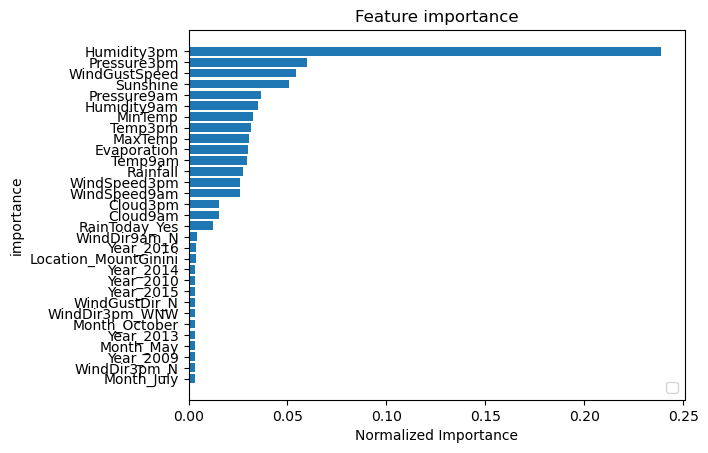

Importance of chosen features:  0.8002626087061405
Number of chosen features =  31


In [37]:
feature_importance = default_tree.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
feature_importance = feature_importance[sorted_idx]
features = X.columns[sorted_idx]
#cumulative_importance = np.cumsum(feature_importance)
#importance_sum = np.sum(feature_importance)
#selected_indices = np.where(cumulative_importance < 0.9 * importance_sum)

cumulative_sum = 0.0
selected_values = []
selected_indices = []

for idx, importance in enumerate(feature_importance):
    cumulative_sum += importance
    selected_values.append(importance)
    selected_indices.append(idx)
    
    if cumulative_sum > 0.8:
        break


plt.barh(features[selected_indices][::-1], feature_importance[selected_indices][::-1], align='center')
plt.xlabel('Normalized Importance')

plt.ylabel('importance')

plt.title(f'Feature importance')
plt.legend(loc='lower right')
plt.show()

print('Importance of chosen features: ', np.sum(feature_importance[selected_indices]))
print('Number of chosen features = ', len(feature_importance[selected_indices]))


Well it turned out that we can delete about 100 of our features and the ones we are left with have over 80% importance of the dataset. 20% is quite a price but from this point every percent would be occupied with additional few features (to get 85% we would've need 48 features and for 90% - 69 features). Remembering that time complexity of training m-feature decision tree is described with O(mlogm), we can see that another few percents would cost us probably a few times more computing time.

In [38]:
X_train_reduced = X_train[features[selected_indices]]
X_test_reduced = X_test[features[selected_indices]]
X_train_reduced.head()

,Humidity3pm,Pressure3pm,WindGustSpeed,Sunshine,Pressure9am,Humidity9am,MinTemp,Temp3pm,MaxTemp,Evaporation,...,Year_2010,Year_2015,WindGustDir_N,WindDir3pm_WNW,Month_October,Year_2013,Month_May,Year_2009,WindDir3pm_N,Month_July
121905,-0.550838,0.220249,-0.506783,0.901321,0.232553,-1.199467,0.721145,0.743427,0.654855,0.154559,...,0,0,0,0,0,0,0,1,0,0
30041,-0.020108,0.349271,-1.021443,0.558403,0.615168,-0.200927,0.282032,0.123559,0.428998,-0.193185,...,0,0,0,0,0,1,0,0,0,0
68052,-2.046534,-0.768920,0.743107,1.402509,-0.759410,-2.776109,1.991436,3.150820,3.096937,1.694566,...,0,0,0,0,0,0,0,0,0,0
25479,-0.695583,-0.969621,1.257767,0.268241,-1.411271,-1.409686,-0.345273,-0.683711,-0.686172,-0.441573,...,0,0,0,1,0,0,0,1,0,1
60866,0.751864,-0.768920,0.449015,-0.786893,-1.085340,1.533379,0.564318,-0.265660,-0.305038,0.899724,...,0,0,0,0,0,0,0,1,0,0


Setting max_depth as well as max_leaf_nodes is a way of preventing our model from ovefitting the data. Similarily min_sample is set to make sure that we dont split our data if its just to bring information about small number of samples. We will also try out different criterion for introducing new split in the tree: 'gini', 'entropy' and 'log_loss'. They evaluate potential split based on reduction in gini impurity, entropy of sample or simple log loss.

In [166]:
tree_cl_param_grid = {
    'max_depth': [None, 5, 10, 15],
    'max_leaf_nodes': [None, 50, 200, 500, 1000],
    'min_samples_split': [2, 10, 50],
    'criterion': ['gini', 'entropy']
}

tree, params = hyperparameter_tuning_cl(X_train_reduced, y_train, X_test_reduced, y_test, 'dec_tree', tree_cl_param_grid, 5, 1)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.87      0.73      6263
           1       0.79      0.49      0.60      6263

    accuracy                           0.68     12526
   macro avg       0.71      0.68      0.67     12526
weighted avg       0.71      0.68      0.67     12526
 

Best parameters:  {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_split': 2}


In [167]:
save_model(tree, 'significant_features_cl_tree')

In [168]:
if 'tree' not in locals():
    tree = load_model('all_features_cl_tree')
    print("Model loaded successfully!")
else:
    print("Model already exists in 'tree' variable.")

Model already exists in 'tree' variable.


And now we'll conduct a little bit more precise hyperparameter tuning based on the best parameters found in the first one.

In [169]:
tree_cl_param_grid_v2 = {
    'max_depth': generate_param_grid(params['max_depth'],5),
    'max_leaf_nodes': generate_param_grid(params['max_leaf_nodes'],5),
    'min_samples_split': generate_param_grid(params['min_samples_split'],5),
    'criterion': [params['criterion']]
}

tree2, params = hyperparameter_tuning_cl(X_train_reduced, y_train, X_test_reduced, y_test, 'dec_tree', tree_cl_param_grid_v2, 5, 1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.87      0.73      6263
           1       0.78      0.49      0.60      6263

    accuracy                           0.68     12526
   macro avg       0.71      0.68      0.66     12526
weighted avg       0.71      0.68      0.66     12526
 

Best parameters:  {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_split': 2}


In [170]:
save_model(tree2, 'significant_features_cl_tree2')

In [171]:
if 'tree2' not in locals():
    tree2 = load_model('significant_features_cl_tree2')
    print("Model loaded successfully!")
else:
    print("Model already exists in 'tree' variable.")

Model already exists in 'tree' variable.


Now we'll visualize feature importances in our tuned and trained model.

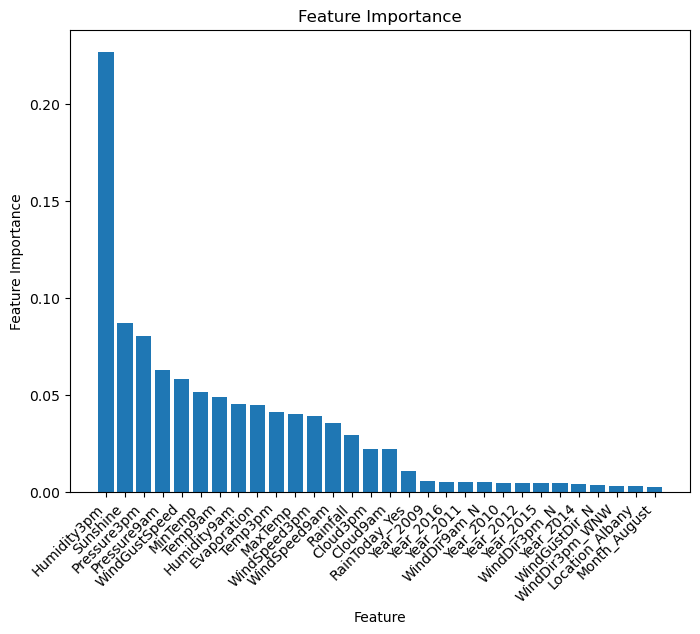

In [172]:
feature_importance = tree2.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importance.argsort()[::-1]

# Plotting feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(len(X_test_reduced.columns[sorted_indices])), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(X_test_reduced.columns[sorted_indices])), X_test_reduced.columns[sorted_indices],  rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

Lets get some insight into interpretation of our tree predictions with help of SHAP library.

100%|===================| 255122/255164 [05:54<00:00]        

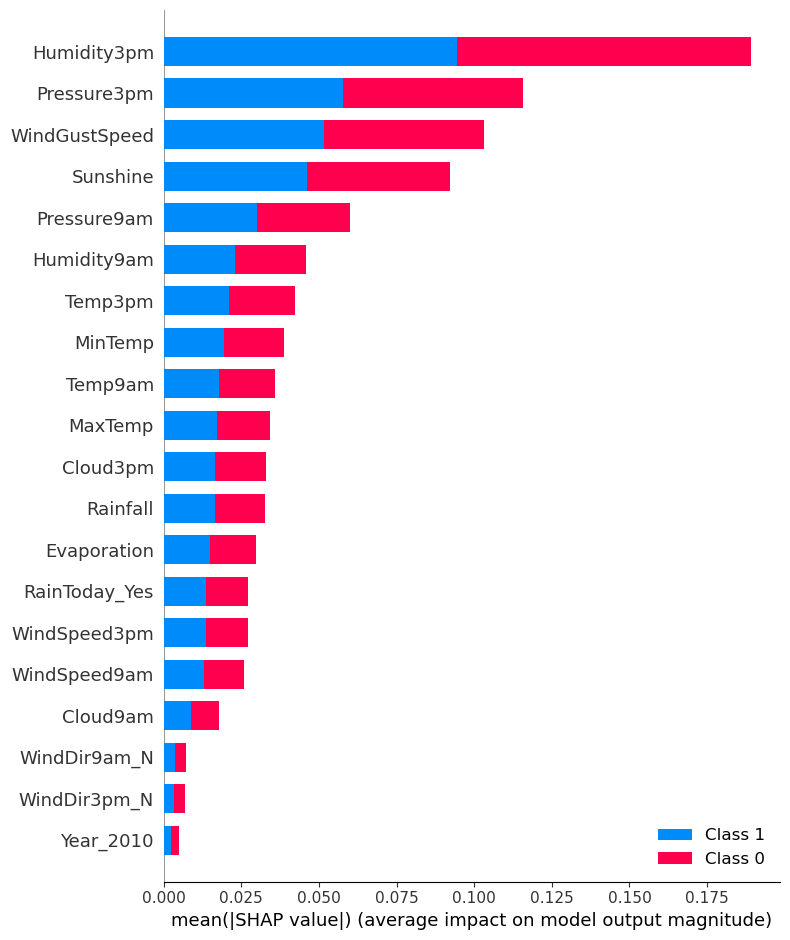

In [174]:
tree_explainer = shap.TreeExplainer(
    tree2, X_train_reduced, feature_names=X_train_reduced.columns.tolist()
)

shap_values = tree_explainer.shap_values(X_train_reduced, y_train)

shap.summary_plot(shap_values, X_train_reduced, plot_type="bar")

We can see that our model definitely got a lot of information from humidity and pressure data. Them as well as sunshine and wind speed features have huge impact on the outcome of our model.

Lets look at the process of estimating one of the instances. We can see what splits it went through and what was the result of the split.

In [175]:
shap.initjs()
shap.force_plot(tree_explainer.expected_value[1], shap_values[1][0], X_train_reduced.iloc[0, :])

### Random Forest Classifier

Here i tried to tune also criterion for splitting, n_estimators and max_features but after over 4 hours of computing I've decided to reduce size of parameter grid, therefore results may be not as good as expected.

In [181]:
forest_cl_param_grid = {
    'max_depth': [None, 8, 12],
    'min_samples_split': [2, 10, 50]
}

forest, forest_params = hyperparameter_tuning_cl(X_train_reduced, y_train, X_test_reduced, y_test, 'rand_forest', forest_cl_param_grid, 3, 2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ................max_depth=None, min_samples_split=2; total time= 1.0min
[CV] END ................max_depth=None, min_samples_split=2; total time=  59.8s
[CV] END ................max_depth=None, min_samples_split=2; total time=  60.0s
[CV] END ...............max_depth=None, min_samples_split=10; total time=  56.7s
[CV] END ...............max_depth=None, min_samples_split=10; total time=  59.2s
[CV] END ...............max_depth=None, min_samples_split=10; total time=  55.1s
[CV] END ...............max_depth=None, min_samples_split=50; total time=  43.1s
[CV] END ...............max_depth=None, min_samples_split=50; total time=  42.3s
[CV] END ...............max_depth=None, min_samples_split=50; total time=  44.2s
[CV] END ...................max_depth=8, min_samples_split=2; total time=  16.7s
[CV] END ...................max_depth=8, min_samples_split=2; total time=  16.5s
[CV] END ...................max_depth=8, min_samp

In [182]:
save_model(forest, 'random_forest_cl')

In [10]:
if 'forest' not in locals():
    forest = load_model('significant_features_cl_tree2')
    print("Model loaded successfully!")
else:
    print("Model already exists in 'tree' variable.")

Model loaded successfully!


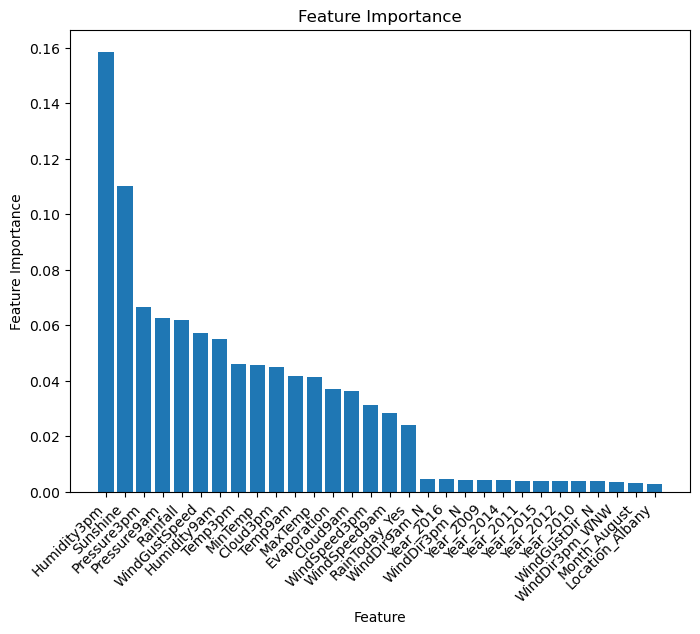

In [184]:
feature_importance = forest.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importance.argsort()[::-1]

# Plotting feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(len(X_test_reduced.columns[sorted_indices])), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(X_test_reduced.columns[sorted_indices])), X_test_reduced.columns[sorted_indices],  rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

Because of the size of dataset, we will calculate shap values based only on 10000 of samples. We can once again see that impact that our features have is similar on class 1 and class 0 which makes sense considering it is a binary classification.

 97%|=================== | 19333/20000 [00:23<00:00]       

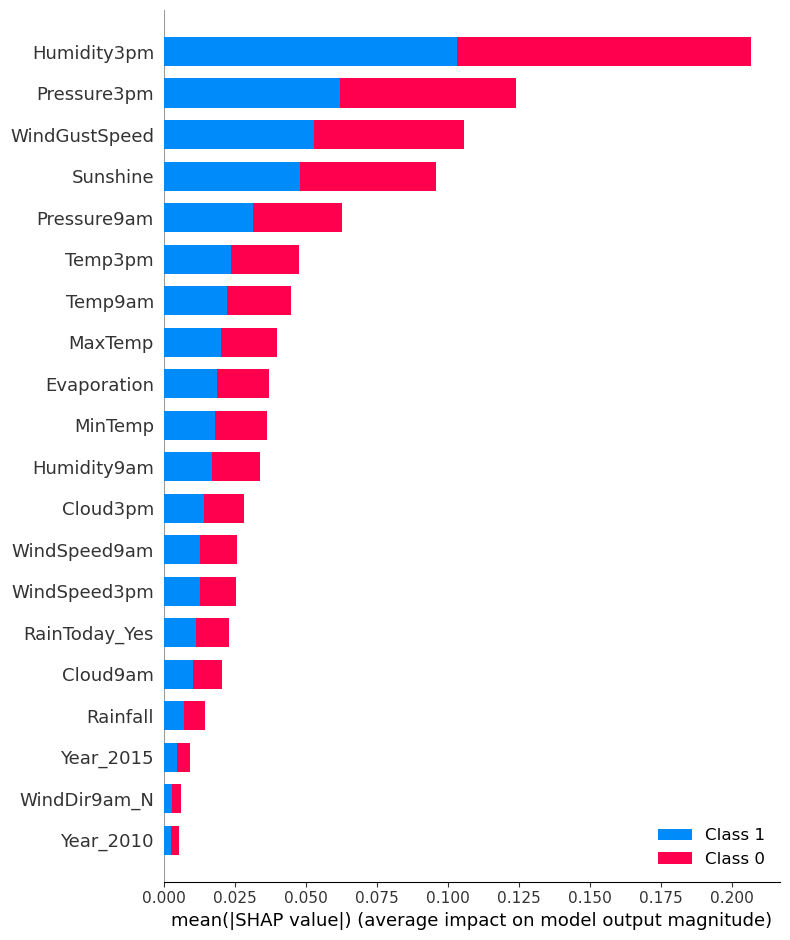

In [40]:
tree_explainer = shap.TreeExplainer(
    forest, X_train_reduced, feature_names=X_train_reduced.columns.tolist()
)

shap_values = tree_explainer.shap_values(X_train_reduced[:10000], y_train[:10000])

shap.summary_plot(shap_values, X_train_reduced, plot_type="bar")

### LightGMB Regressor

In [42]:
lgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [70, 100, 120],         
    'max_depth': [None, 5, 10],
    'reg_alpha': [0.0, 0.1, 0.5],  
}

booster, lgbm_params = hyperparameter_tuning_cl(X_train_reduced, y_train, X_test_reduced, y_test, 'boosting', lgb_param_grid, 4, 2)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.0; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.0; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.0; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.0; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.1; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.1; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.1; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.1; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.5; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=None, n_estimators=70, reg_alpha=0.

In [43]:
save_model(booster, 'lgbm_cl')

In [45]:
if 'booster' not in locals():
    booster = load_model('lgbm_cl')
    print("Model loaded successfully!")
else:
    print("Model already exists in 'tree' variable.")

Model already exists in 'tree' variable.


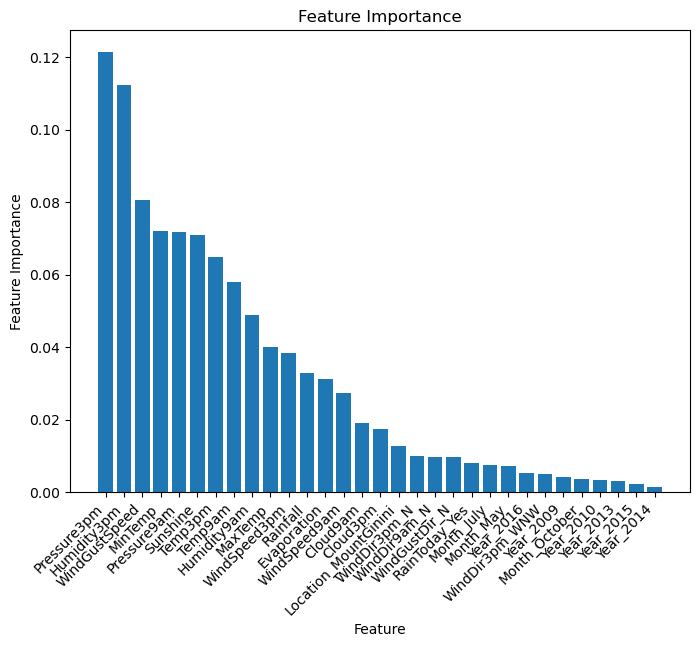

In [49]:
feature_importance = booster.feature_importances_
feature_importance = feature_importance / np.sum(feature_importance)

# Sort feature importances in descending order
sorted_indices = feature_importance.argsort()[::-1]

# Plotting feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(len(X_test_reduced.columns[sorted_indices])), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(X_test_reduced.columns[sorted_indices])), X_test_reduced.columns[sorted_indices],  rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

 99%|===================| 9915/10000 [01:01<00:00]        

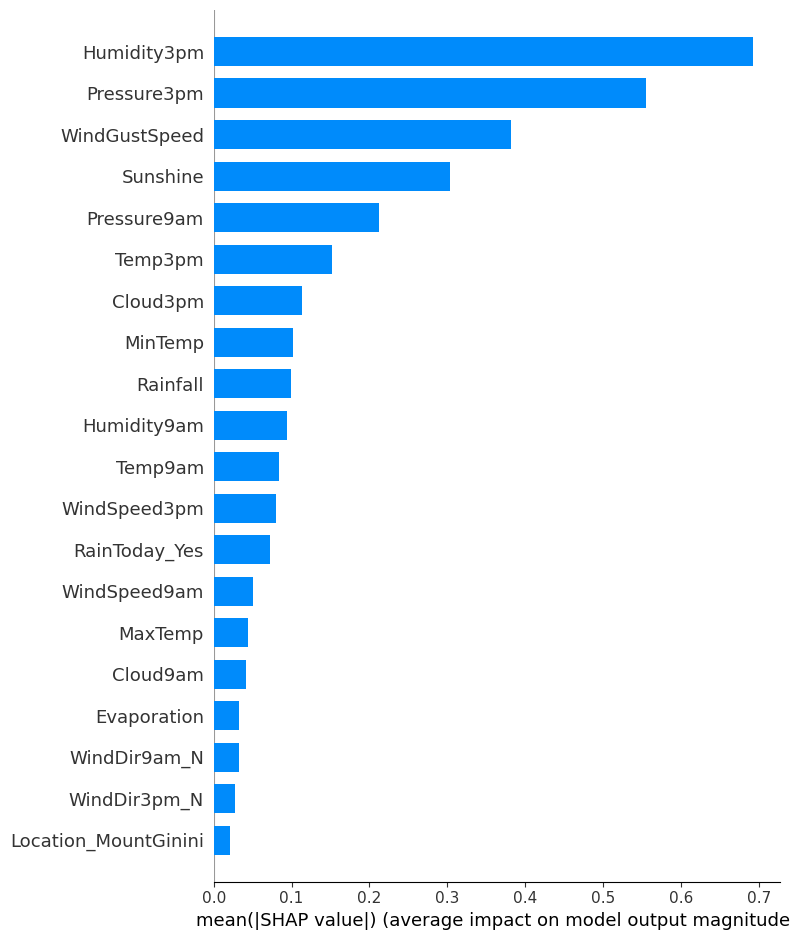

In [51]:
tree_explainer = shap.TreeExplainer(
    booster, X_train_reduced, feature_names=X_train_reduced.columns.tolist()
)

shap_values = tree_explainer.shap_values(X_train_reduced[10000:20000], y_train[10000:20000])

shap.summary_plot(shap_values, X_train_reduced, plot_type="bar")

## CONCLUSIONS

Overall our models reached f1 scores, and accuracies:
 - decision tree -> 0.60, 0.68
 - random forest -> 0.66, 0.73
 - lgbm gradient boosting algorithm ->  0.78, 0.79

Compared to the results of the last homework (comparison will be based on accuracy because it was the measure chosen in last homework):
 - logistic regression -> 0.7817339932939485
 - knn ->  0.70
 - naive bayes -> 0.63
 - svm -> 0.78

We can see that lgbm gradient boosting performed the best from those model and with more sophisticated tuning it would probably be even better. Random forest performance was average however also with better tuning it would porbably have a chance to compete with svm and logistic regression.Decision tree was better only than naive bayes. 
<br>
Looking at all of the investigated models, gradient boosting seems to be the best approach to our problem, however its important to be careful not to overfit the model.